In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 13
plt.rcParams['axes.spines.right'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['xtick.top'] = False

## Finite sample effects and bias correction

The benefits of using mutual information as a measure of information (or correlation) can often be limited in practice due to a finite sample effect. So far, we have always assumed that the probability distributions that go into the calculations are known, and in these situations, it is straight forward to determine the various entropies, and thus also the mutual information. In practice, however, we usually only have access to samples from the distributions, and the probabilities $p_1,\ldots,p_n$ are therefore not know but estimated from a finite sample. Consequently, our estimated distributions are not exact matches of the true distributions, and thus their entropies also differ.

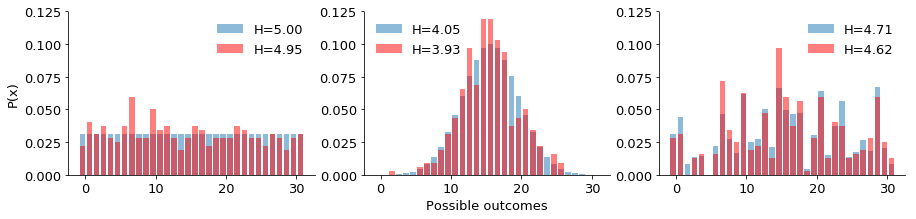

In [2]:
# Entropies for estimates of various example distributions
N = 32
mu = N/2.
sigma = N/8.
n_sample_size = 10*N
x = np.arange(N)
bin_edges = np.append(x-0.5, N + 0.5)

# Distributions
p_equal = 1./N*np.ones(N) 
p_normal = np.exp(-(x-mu)**2/(2*sigma**2))
p_normal /= p_normal.sum()
p_random = np.random.rand(N)
p_random /= p_random.sum()
ps = [p_equal, p_normal, p_random]
p_max = np.hstack(ps).max()

# Plotting
plt.figure(figsize=(15, 3))
for idx, p in enumerate(ps, start=1):
    H_true = -np.sum(p*np.log2(p))
    
    # Estimates distribution based on n_samples drawn from the true distribution
    p_cum = np.cumsum(p)
    rs = np.random.rand(n_sample_size)
    sample = np.array([np.argmax(r < p_cum) for r in rs])
    counts, _ = np.histogram(sample, bin_edges)
    p_est = np.float64(counts) / counts.sum()
    H_est = -np.sum(p_est[p_est>0]*np.log2(p_est[p_est>0]))
    
    ax = plt.subplot(1, len(ps), idx)
    ax.bar(x-0.4, p, alpha=0.5)
    ax.bar(x-0.4, p_est, color='r', alpha=0.5)
    ax.legend(['H=%3.2f' % H_true, 'H=%3.2f' % H_est], frameon=False, loc=0)
    ax.set_ylim([0, p_max*1.25])
    if idx == 1:
        ax.set_ylabel('P(x)')
    elif idx == 2:
        ax.set_xlabel('Possible outcomes')

As the examples above show, the entropy is underestimated for all estimated distributions. This is an observation that holds in general independently of what the original true probability distribution looks like. Most importantly, however, one should note that simple averaging does not solve the problem, and for this reason the underestimation is referred to as a finite sample bias.

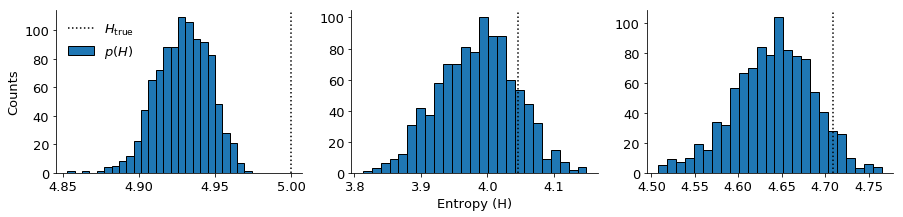

In [3]:
# The entropy mean of repeatedly estimates does not converge to the true entropy
n_reps = 1000

plt.figure(figsize=(15, 3))
for idx, p in enumerate(ps, start=1):
    
    Hs = []
    p_cum = np.cumsum(p)
    H_true = -np.sum(p[p>0]*np.log2(p[p>0]))
    
    # Calculate the entropy repeatedly for various estimated distributions
    for rep in range(n_reps):
        
        # Estimates distribution based on n_samples and calculate the entropy
        rs = np.random.rand(n_sample_size)
        sample = np.array([np.argmax(r < p_cum) for r in rs])
        counts, _ = np.histogram(sample, bin_edges)
        p_est = np.float64(counts) / counts.sum()
        H_est = -np.sum(p_est[p_est>0]*np.log2(p_est[p_est>0]))
        Hs.append(H_est)
    
    # Plot a histogram on found entropies as well as the true value
    ax = plt.subplot(1, 3, idx)
    ax.hist(np.array(Hs), 25, ec='k', align='mid', label='$p(H)$')
    ax.axvline(H_true, color='black', ls=':', label='$H_\mathrm{true}$')
    if idx == 1:
        ax.set_ylabel('Counts')
        ax.legend(frameon=False)
    elif idx == 2:
        ax.set_xlabel('Entropy (H)')
        

In practice, one can correct for the finite sample bias using at least any of the following three approaches:
1. Gather more data or reduce the number of outcomes until the bias becomes negligible (the bias is proportional to the number of outcomes and inversely proportional to the number of samples). The intuition being that the more data that is used to estimate each $P_i$ the smaller bias.
2. Use a quadratic or linear extrapolation to infer what the estimated entropy would be for infinite data (explained in detail below).
3. Approximate the true distribution using a model distribution with fewer parameters than the number of outcomes (requires some knowledge of what the true distribution looks like). 

### Quadratic or linear extrapolation

The above results illustrate that the entropy (and thus also the bias) can vary widely between various estimates of the true distribution. However, a Taylor expansion shows that in the well sample regime (sample size $>> N$), the bias is inversely proportional to the mean of the distributions above. It is thus possible to do a bias correction by first calculating the mean $H$ values for various fractions of the data, and then performing a linear (or quadratic) extrapolation to infinite data.

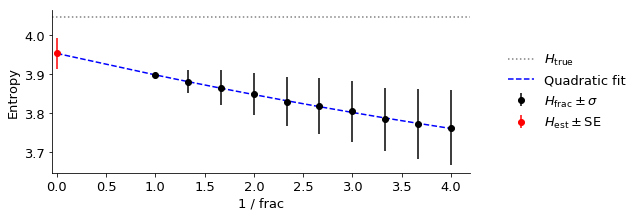

In [4]:
n_fracs = 10  # Number of various fractions of the data that the mean entropy is estimated for
p = p_normal  # Selcting one of three example distributions above

H_true = -np.sum(p[p>0]*np.log2(p[p>0]))
fracs = 1. / np.linspace(1, 4, n_fracs)

# Generate n_samples from the selected distribution
p_cum = np.cumsum(p)
rs = np.random.rand(n_sample_size)
sample = np.array([np.argmax(r < p_cum) for r in rs])

# Define function for calculating entropies of fractional subsamples
def fracSampleH(sample, fracs, n_reps):
    
    # Loop over data fractions
    n_fracs = fracs.size
    Hs = np.zeros([n_reps, n_fracs])
    for frac_id, frac in enumerate(fracs):

        # Convert fraction to a count
        n_samples_tmp = np.int64(frac*sample.size)

        # Calculate the entropy repeatedly for various subsamples
        for rep_id in range(n_reps):

            # Subsample from the original sample
            r_perm = np.random.permutation(sample.size)
            counts, _ = np.histogram(sample[r_perm[:n_samples_tmp]], bin_edges)
            p_est = np.float64(counts) / counts.sum()
            Hs[rep_id, frac_id] = -np.sum(p_est[p_est>0]*np.log2(p_est[p_est>0]))
            
    return Hs

# Get entropies for various fractions of the data
Hs = fracSampleH(sample, fracs, n_reps)
       
# Least squares quadratic extrapolation
A = np.hstack([np.ones([n_fracs, 1]), 1. / fracs[:, np.newaxis], 1. / fracs[:, np.newaxis]**2])
w = np.linalg.lstsq(A, Hs.mean(axis=0))[0]
A = np.insert(A, 0, [1, 0, 0], 0)
fit = np.dot(A, w)

# This way of estimating the standard error is justified below
se = Hs[:, 3].std() / np.sqrt(2)
    
# Plotting
plt.figure(figsize=(7.5, 3))
plt.axhline(H_true, c='gray', ls=':', label='$H_\mathrm{true}$')
plt.errorbar(1. / fracs, Hs.mean(axis=0), yerr=Hs.std(axis=0), fmt='ko', label='$H_\mathrm{frac}\pm\sigma$')
plt.plot(A[:, 1], fit, 'b--', label='Quadratic fit')
plt.errorbar(0, w[0], yerr=se, fmt='ro', label='$H_\mathrm{est}\pm\mathrm{SE}$')
plt.xlim([-0.05, 1.05/fracs[-1]]);
plt.xlabel('1 / frac')
plt.ylabel('Entropy')
plt.legend(frameon=False, bbox_to_anchor=(1, 0, 0.4, 1), loc=5);

Unfortunately, the bias correction is only correct on average (note that the extrapolation gives a different result each time the cell above is run). Bialek (2012) estimates the SE of the results as $\sigma$ at $N/2$ divided by $\sqrt{2}$, but without providing a motivation. However, most likely this represents a rough approximation in the well sampled regime (sample size $>> N$) where the variation in the results should stem from vertical movement of the blue line above. That is, the variation stems from the uncertainty in the entropy means at each fraction. The distribution of the means should in turn be Gaussian (central limit theorem) with a standard deviation given by $\sigma / \sqrt{n_\mathrm{observations}}$. At $N/2$, we effectively only have two independent observation and thus one arrives at $\sigma / \sqrt{2}$. This is, nonetheless, not exact for at least two reasons: 1) an under-estimation bias of $\sigma$ due to sub-sampling (leads to underestimation of the SE), and 2) an over-estimation bias of $\sigma$ due to it being estimated at only half the sample size. As illustrated below, these factors appear to cancel quite well, and consequently the SE estimated as $\sigma / \sqrt{2}$ at $N/2$ does put us in the right ballpark. 

The next question to ask is under which circumstances the bias correction procedure gives the correct result on average (i.e., under what conditions does the mean of the result distribution converge to the true entropy). Panzeri et al. (2007) concluded that one roughly needs at least four observations per $p_i$ on average, and running the cell below a few times for varying sample sizes indicates that this number might be a bit low (somewhere between 5 and 10 might be more correct). As a comparison, Panzeri et al. (2007) found that one needed at least 32 observations per $p_i$ on average before the bias becomes negligible if no bias correction method is used.

0.042480287308
0.0492818223316
0.0511130816226


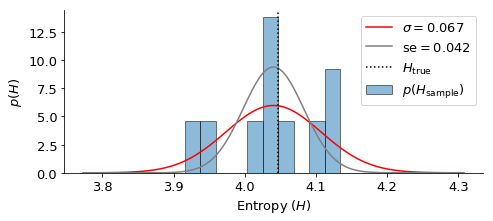

In [5]:
# This will take a few minutes when n_samples is roughly a few hudred
n_samples = 10

H_samples = []
ses_half = []
ses_third = []
ses_fourth = []
for sample_id in range(n_samples):
    
    # Generate a new sample
    rs = np.random.rand(n_sample_size)
    sample = np.array([np.argmax(r < p_cum) for r in rs])
       
    # Get mean entropies for each fractions and extrapolate
    Hs_tmp = fracSampleH(sample, fracs, n_reps)
    A = np.hstack([np.ones([n_fracs, 1]), 1. / fracs[:, np.newaxis], 1. / fracs[:, np.newaxis]**2])
    w = np.linalg.lstsq(A, Hs_tmp.mean(axis=0))[0]
    
    # SE at 1/frac equal to 2, 3, and 4 
    ses_half.append(Hs_tmp[:, 3].std() / np.sqrt(2))
    ses_third.append(Hs_tmp[:, 6].std() / np.sqrt(3))
    ses_fourth.append(Hs_tmp[:, 9].std() / np.sqrt(4))
    H_samples.append(w[0])

print np.mean(ses_half)  
print np.mean(ses_third)  
print np.mean(ses_fourth)  
se_mean = np.mean(ses_half)  

# Fitted Gaussians: 1) N(mu, sigma) and 2) N(mu, SE^2)
H_mu = np.array(H_samples).mean()
H_std = np.array(H_samples).std()
points = np.linspace(H_mu-4*H_std, H_mu+4*H_std, 100)
gauss_est = 1 / np.sqrt(2*np.pi*H_std**2) *np.exp(-(H_mu-points)**2 / (2*H_std**2))
gauss_se = 1 / np.sqrt(2*np.pi*se_mean**2) *np.exp(-(H_mu-points)**2 / (2*se_mean**2))

# Plotting
plt.figure(figsize=(7.5, 3))
plt.hist(H_samples, ec='k', density=True, alpha=0.5, label='$p(H_\mathrm{sample})$')
plt.plot(points, gauss_est, 'r-', label='$\sigma=%3.3f$' % H_std)
plt.plot(points, gauss_se, c='gray', ls='-', label='$\mathrm{se}=%3.3f$' % se_mean)
plt.axvline(H_true, c='k', ls=':', label='$H_\mathrm{true}$')
plt.legend();
plt.xlabel('Entropy ($H$)')
plt.ylabel('$p(H)$');

### Approximating the true distribution with a parametric one

To the best of our knowledge, there is no known reliable bias correction procedure when the number of average observations per $p_i$ drops below $\approx5$. In such situations, one have to accept that it is no longer possible to estimate the entropy without additional assumptions. One such assumption could be to approximate the true distribution with a parametric one, for example a Gaussian or a maximum entropy model. This will obviously only work if the parametric distribution is a very good approximation of the true one, but this might occasionally be the case. The central limit theorem, for example, might tell us that the true distribution is a Gaussian in which case we only need to fit two parameters (the mean and the variance). In such situations, we can manage with sample sizes that are clearly below five observations per $p_i$.

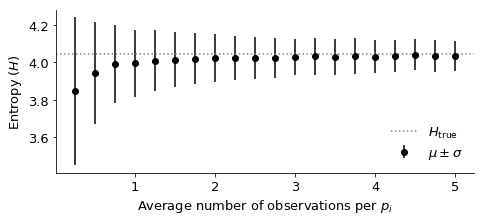

In [6]:
# Try to fit a normal distribution to observations from the selected true distribution
sample_sizes = np.int64(np.arange(0.25, 5.1, 0.25) * N)

# Loop over various sample sizes
H_approx = np.zeros([n_reps, len(sample_sizes)])
for size_id, sample_size in enumerate(sample_sizes):
    
    # Repetition loop
    for rep_id in range(n_reps):
                     
        # Generate sample_size observations from the selected distribution
        rs = np.random.rand(sample_size)
        sample = np.array([np.argmax(r < p_cum) for r in rs])
        # Fit a normal distribution and estimate its entropy
        mu_tmp = sample.mean()
        sigma_tmp = sample.std()
        p_tmp = np.exp(-(x-mu_tmp)**2/(2*sigma_tmp**2))
        p_tmp /= p_tmp.sum()
        H_tmp = -np.sum(p_tmp[p_tmp>0]*np.log2(p_tmp[p_tmp>0]))
        H_approx[rep_id, size_id] = H_tmp

# Summary statistics
H_mean = H_approx.mean(axis=0)
H_sigma = H_approx.std(axis=0)
obs_per_p = sample_sizes / np.float64(N)

# Plotting
plt.figure(figsize=(7.5, 3))
plt.errorbar(obs_per_p, H_mean, yerr=H_sigma, fmt='ko', label='$\mu\pm\sigma$')
plt.axhline(H_true, ls=':', c='gray', label='$H_\mathrm{true}$')
plt.legend(loc=4, frameon=False)
plt.xlabel('Average number of observations per $p_i$')
plt.ylabel('Entropy ($H$)');

The figure above illustrates that when we only need to estimate the mean and the variance from our sample, then we will on average get the right entropy using only $\approx 1.5$ observations per $p_i$ (assuming the true distribution is a Gaussian). Thus, being able to describe the true distribution on a parametric form might make it possible to estimate entropies correctly even when we have less than five sample per $p_i$.

### Finite sample effects on the mutual information

The conditional entropy suffers $H(X|Y)$ from the same bias as the entropy $H(X)$ when estimated from a sample. The mutual information $H(X) - H(X|Y)$ is therefore determined from two quantities which both suffer from a finite sample bias, and which therefore likely are underestimated unless the bias is corrected for. Nonetheless, one might hope that the bias would not affect the mutual information as it corresponds to the difference between the entropy and the conditional entropy (if both quantities are biased by the same amount, then the difference is unaffected). Sadly, this is not the case: The reason being that the bias is inversely proportional to the number of observations, and as the conditional entropy is estimated from fewer observations, it will have a larger bias. This also means that mutual information estimates will be overestimated unless the bias is corrected for: we subtract off to little when $H(X|Y)$ is more biased than $H(X)$. 

## Continuous probability distributions

It is incredibly tempting to assume that one can replace the sum in the expression for the entropy with an integral when dealing with continuous distributions. However, doing so would be a big mistake. The easiest way to understand this is to approximate the probability distribution $P(x)$ with bins of decreasing width $\Delta x$. The entropy of the approximated distributions can then be determined by noting that the individual probabilities are $p_i=P(x_i)*\Delta x$. Disturbingly, these successive approximations indicate that the entropy approaches infinity as $\Delta x$ goes towards zero.

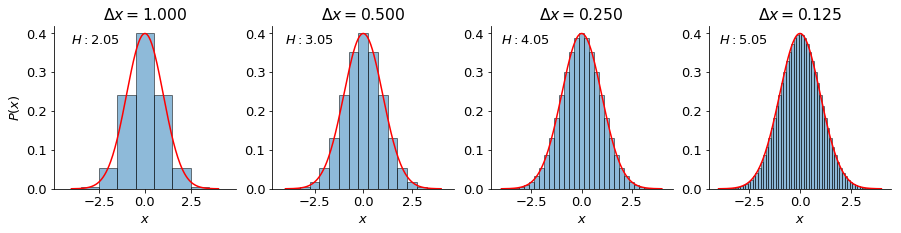

In [7]:
# Gaussian distributions with increasing number of outcomes 
deltas = 2**np.arange(0., -4., -1)
x_con = np.linspace(-4.0, 4.0, 200)
p_con = 1./np.sqrt(2*np.pi) * np.exp(-x_con**2/2)

plt.figure(figsize=(15, 3))
for i, delta in enumerate(deltas, start=1):
    
    x_bar = np.arange(-4.0, 4.1, delta)
    px_bar = 1./np.sqrt(2*np.pi) * np.exp(-x_bar**2/2)  # P(x_i)
    pi_bar = px_bar*delta  # p_i
    H_bar = -np.sum(pi_bar[pi_bar>0]*np.log2(pi_bar[pi_bar>0]))  # Entropy
    
    #Plotting
    ax = plt.subplot(1, len(deltas), i)
    ax.bar(x_bar, px_bar, delta, alpha=0.5, ec='k')
    ax.plot(x_con, p_con, 'r-')
    ax.set_title('$\Delta x = %1.3f$' % delta)
    ax.text(x_con.min(), p_con.max(), '$H:%1.2f$' % H_bar, ha='left', va='top')
    ax.set_xlabel('$x$')
    if i == 1:
        ax.set_ylabel('$P(x)$')

This increase towards infinity appears even stranger when you look at the Wiki page for the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution), and discover a finite expression for the distributions entropy: $H=\frac{1}{2\log(2)} \log(2\pi e \sigma^2)$. In order to make sense of this mess we need to look at the expression used to estimate the distribution's entropy at various $\Delta x$ values, that is

$$
\begin{align}
  H &= -\sum_i P(x_i)\Delta x \log_2 \left( P(x_i)\Delta x \right), \\
    &= -\sum_i P(x_i)\Delta x \log_2 \left( P(x_i) \right) -\sum_i P(x_i)\Delta x \log_2 \left( \Delta x \right), \\
    &= -\sum_i P(x_i)\Delta x \log_2 \left( P(x_i) \right) -\log_2 \left( \Delta x \right),
\end{align}
$$

where the first term in the last expression becomes $-\int P(x)\log_2 \left( P(x) \right)$ as $\Delta x \to 0$. Thus, the entropy for a continuous distribution can be broken up into two parts: one that remains finite $-\int P(x)\log_2 \left( P(x) \right)$ and one that becomes infinite $-\log_2 \left( \Delta x \right)$ as $\Delta x \to 0$. The finite part is specifically named differential entropy, so as to separate it from the ordinary entropy, which only exist for discrete probability distributions. However, sometimes the differential part is left out (as on the Wiki page) which easily leads to confusion. 

Entropy obtained using the analytic expression from Wikipedia: 2.05
2.04703754732
2.04680946612
2.04656103017
2.04639297862


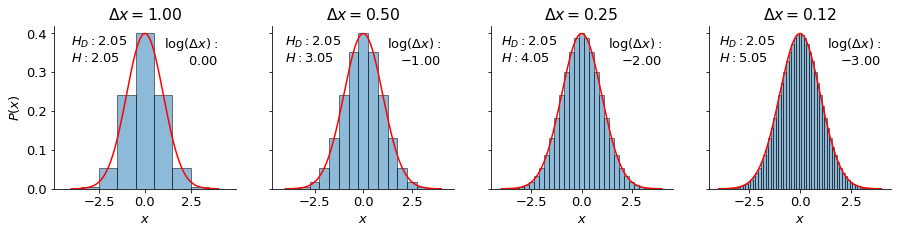

In [8]:
H_diff_gaussian = 1./2./np.log(2) * np.log(2*np.pi*np.exp(1))  # taken from wikipedia
print('Entropy obtained using the analytic expression from Wikipedia: %1.2f' % H_diff_gaussian)

plt.figure(figsize=(15, 3))
for i, delta in enumerate(deltas, start=1):
    
    x_bar = np.arange(-4.0, 4.1, delta)
    px_bar = 1./np.sqrt(2*np.pi) * np.exp(-x_bar**2/2)  # P(x_i)
    pi_bar = px_bar*delta  # p_i
    H_bar = -np.sum(pi_bar[pi_bar>0]*np.log2(pi_bar[pi_bar>0]))  # Entropy
    H_diff = -np.sum(pi_bar[pi_bar>0]*np.log2(px_bar[px_bar>0]))  # Differential entropy
    print H_diff
    
    #Plotting
    ax = plt.subplot(1, len(deltas), i)
    ax.bar(x_bar, px_bar, delta, alpha=0.5, ec='k')
    ax.plot(x_con, p_con, 'r-')
    ax.set_title('$\Delta x = %2.2f$' % delta)
    info_l = '$H_D : %1.2f$\n$H : %1.2f$' % (H_diff, H_bar)
    info_r = '$\log(\Delta x):$\n$%1.2f$' % np.log2(delta)
    ax.text(x_con.min(), p_con.max(), info_l, ha='left', va='top')
    ax.text(x_con.max(), p_con.max(), info_r, ha='right', va='top')
    ax.set_xlabel('$x$')
    if i == 1:
        ax.set_ylabel('$P(x)$')
    else:
        ax.set_yticklabels([])

In real situations it might be slightly more difficult to estimate the differential entropy as $P(x_i)$ is unknown. In practice, it means that a certain number of minimum bins are needed in order to approximate the true distribution good enough. This is illustrated below, where we see how the differential entropy approaches its true value as the number of bins are increased.

Entropy obtained using the analytic expression from Wikipedia: 2.05


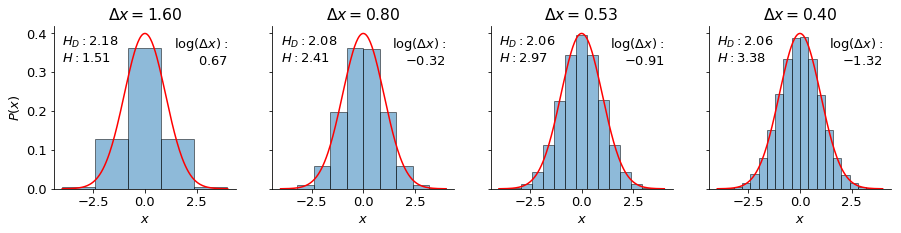

In [9]:
H_diff_gaussian = 1./2./np.log(2) * np.log(2*np.pi*np.exp(1))  # taken from wikipedia
print('Entropy obtained using the analytic expression from Wikipedia: %1.2f' % H_diff_gaussian)

n_bins = np.arange(5, 21, 5)
plt.figure(figsize=(15, 3))
for i, bins in enumerate(n_bins, start=1):
    
    # Generate many observations so as to make the finite sample bias neglieble
    x = np.random.randn(int(1e6))
    # Place the bins linearly between -4std .. +4std
    x_edges = np.linspace(x.mean()-4*x.std(), x.mean()+4*x.std(), bins+1)
    dx = x_edges[1] - x_edges[0]
    x_counts = np.histogram(x, x_edges)[0]
    px = np.float64(x_counts) / x_counts.sum()
    H_bar = -np.sum(px[px>0]*np.log2(px[px>0]))  # entropy
    H_diff = -np.sum(px[px>0]*np.log2(px[px>0]/dx))  # differential entropy
    
    #Plotting
    ax = plt.subplot(1, len(n_bins), i)
    ax.bar(x_edges[:-1]+dx/2, px/dx, dx, alpha=0.5, ec='k')
    ax.plot(x_con, p_con, 'r-')
    ax.set_title('$\Delta x = %2.2f$' % dx)
    info_l = '$H_D : %1.2f$\n$H : %1.2f$' % (H_diff, H_bar)
    info_r = '$\log(\Delta x):$\n$%1.2f$' % np.log2(dx)
    ax.text(x_con.min(), p_con.max(), info_l, ha='left', va='top')
    ax.text(x_con.max(), p_con.max(), info_r, ha='right', va='top')
    ax.set_xlabel('$x$')
    if i == 1:
        ax.set_ylabel('$P(x)$')
    else:
        ax.set_yticklabels([])

### Mutual information for continuous distributions

Mutual information calculations are usually spared from the trouble of infinite entropies, as the information is obtained as the difference between an entropy and a conditional entropy. That is, the $\log(\Delta x)$ terms cancel when performing the subtraction. However, care must be taken whenever the continuous distributions are approximated by binned histograms, so as to ensure that $\Delta x$ is the same for all approximations.